In [ ]:
# Instalación de dependencias para Google Colab
!pip install deltalake
!pip install pyarrow
!pip install pandas
!pip install requests
!pip install numpy
!pip install matplotlib

In [1]:
import os, time, requests
import pandas as pd
from deltalake import write_deltalake, DeltaTable
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

## Funciones de carga de datos desde Silver

In [2]:
def load_silver_coin_list():
    """
    carga la lista de monedas desde el Delta Lake.
    retorna: un DataFrame de pandas con la lista de monedas disponibles en la Api.
    """
    path="silver/coingecko_api/coins_list"
    try:
        table=DeltaTable(path)
        arrow_table=table.to_pyarrow_table()
        df= arrow_table.to_pandas()
        
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Ruta no encontrada: {path}")
    except Exception as e:
        # Captura cualquier otro error (DeltaCorruption, permisos, etc.)
        raise RuntimeError(f"Error cargando datos de Delta Lake en {path}: {e}")

def load_silver_coins_markets_latest():
    """
    Carga solo los datos más recientes del endpoint coins/markets
    retorna: un DataFrame de pandas con los datos más recientes del mercado de criptomonedas.
    """
    path = "silver/coingecko_api/coins_markets"
    try:
        # Cargar toda la tabla
        table = DeltaTable(path)
        df = table.to_pyarrow_table().to_pandas()
        
        # Obtener la fecha más reciente
        latest_date = df['extract_date'].max()
        
        # Filtrar solo esa fecha
        df_latest = df[df['extract_date'] == latest_date].copy()
        
        print(f"📅 Fecha más reciente: {latest_date}")
        print(f"📊 Registros de la última extracción: {len(df_latest)}")
        
        return df_latest
    except FileNotFoundError:
        raise FileNotFoundError(f"Ruta no encontrada: {path}")
    except Exception as e:
        # Captura cualquier otro error (DeltaCorruption, permisos, etc.)
        raise RuntimeError(f"Error cargando datos de Delta Lake en {path}: {e}")



def load_silver_market_chart_latest():
    """
    Carga solo los datos más recientes del endpoint coins/markets
    retorna: un DataFrame de pandas con los datos de los ultimos 30 dias de las 5 mejores monedas del mercado de criptomonedas, toma el dataframe almacenado mas reciente
    """
    path = "silver/coingecko_api/market_chart"
    try:
        # Cargar toda la tabla
        table = DeltaTable(path)
        df = table.to_pyarrow_table().to_pandas()
        
        # Obtener la fecha más reciente
        latest_date = df['extract_date'].max()
        
        # Filtrar solo esa fecha
        df_latest = df[df['extract_date'] == latest_date].copy()
        
        print(f"📅 Fecha más reciente: {latest_date}")
        print(f"📊 Registros de la última extracción: {len(df_latest)}")
        
        return df_latest
    except FileNotFoundError:
        raise FileNotFoundError(f"Ruta no encontrada: {path}")
    except Exception as e:
        # Captura cualquier otro error (DeltaCorruption, permisos, etc.)
        raise RuntimeError(f"Error cargando datos de Delta Lake en {path}: {e}")


# TRANSFORMACION Y AGREGACIONES

In [ ]:
def load_and_combine_crypto_data_for_gold_layer():
    """
    Función para combinar datos actuales e históricos.
    
    Args:
        df_current: DataFrame con datos actuales (columnas: id, symbol, name, current_price, etc.)
        df_historical: DataFrame histórico (columnas: coin_id, date, prices, market_caps, total_volumes)
    
    Returns:
        pd.DataFrame: DataFrame combinado para capa gold
    """
    
    print("🔄 Combinando DataFrames...")
    
    df_current=load_silver_coins_markets_latest()
    df_historical=load_silver_market_chart_latest()
    
    # 1. Preparar DataFrame actual
    df_current_prep = df_current.copy()
    df_current_prep = df_current_prep.rename(columns={
        'id': 'coin_id',
        'current_price': 'price'
    })
    # Agregar fecha actual
    df_current_prep['date'] = df_current_prep['extract_date']  # Usar extract_date como date
    
    # 2. Preparar DataFrame histórico  
    df_historical_prep = df_historical.copy()
    df_historical_prep = df_historical_prep.rename(columns={
        'prices': 'price',
        'market_caps': 'market_cap',
        'total_volumes': 'total_volume'
    })
    
    # 3. Agregar columnas faltantes al histórico con -1
    current_columns = set(df_current_prep.columns)
    historical_columns = set(df_historical_prep.columns)
    missing_columns = current_columns - historical_columns
    
    # rellenamos los nulos en el DataFrame histórico
    for col in missing_columns:
        if col in ["symbol", "name"]:
            df_historical_prep[col] = 'not available'
        elif col in ["ath_date"]:
            df_historical_prep[col] = pd.NaT
        else:
            df_historical_prep[col] = -1
    
    # 4. Asegurar mismo orden de columnas
    column_order = list(df_current_prep.columns)
    df_historical_final = df_historical_prep[column_order]
    
    # 5. Combinar DataFrames
    df_combined = pd.concat([
        df_current_prep,
        df_historical_final
    ], ignore_index=True)
    
    # 6. Ordenar por coin_id y date
    df_combined = df_combined.sort_values(['coin_id', 'date']).reset_index(drop=True)
    
    print(f"✅ Combinación exitosa:")
    print(f"   - Total filas: {len(df_combined):,}")
    print(f"   - Columnas: {len(df_combined.columns)}")
    print(f"   - Criptomonedas: {df_combined['coin_id'].nunique()}")
    
    return df_combined


def price_change(df_combined):
    """
    calcula el cambio en el precio de las criptomonedas en los últimos 30 días.
    representa el primer y último precio de cada moneda y el porcentaje de cambio en los últimos 30 días.
    Args:
        df_combined: DataFrame combinado con datos de criptomonedas. 
    Returns:
        pd.DataFrame: DataFrame con columnas: coin_id, first_price, last_price, pct_change_30d, extract_date
    """
    print("📊 Calculando market cap y total volume...")
    
    # 1. Filtramos solo las monedas que nos interesan
    monedas = ["bitcoin", "ethereum", "tether", "ripple", "binancecoin"]
    df = df_combined[df_combined['coin_id'].isin(monedas)].copy()
    
    # 2. Asegurarse de que 'date' sea datetime y ordenar
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values(['coin_id', 'date'])
    
    # 3. Agrupar y extraer primer y último precio + extract_date
    resumen = (df
        .groupby('coin_id')
        .agg({
            'price': ['first', 'last'],
            'extract_date': 'first'  # tambien agregamos la fecha de extracción para el particionamiento al guardar
        })
        .reset_index()
    )
    
    # 4. Aplanar los nombres de columnas
    resumen.columns = ['coin_id', 'first_price', 'last_price', 'extract_date']
    
    # 5. Calcular el porcentaje de cambio
    resumen['pct_change_30d'] = (resumen['last_price'] - resumen['first_price']) \
                                / resumen['first_price'] * 100
                                
    return resumen


def price_change_visualization(df):
    """
    Visualiza el cambio de precio de las criptomonedas en los últimos 30 días.
    Args:
        df: DataFrame con columnas: coin_id, first_price, last_price, pct_change_30d
    """

    # Configuración del gráfico
    plt.figure(figsize=(12, 6))
    plt.bar(df['coin_id'], df['pct_change_30d'], color='skyblue')
    plt.title('Cambio de Precio de Criptomonedas en los Últimos 30 Días')
    plt.xlabel('Criptomoneda')
    plt.ylabel('Cambio (%)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Almacenamiento capa gold

In [5]:
GOLD_PATH="gold/coingecko_api"


def ensure_directory_exists(path):
    """
    Asegura que el directorio existe, si no lo crea automáticamente
    Compatible con Google Colab
    """
    try:
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
            print(f"✓ Directorio creado: {path}")
        else:
            print(f"✓ Directorio ya existe: {path}")
    except Exception as e:
        print(f"Error creando directorio {path}: {e}")
        raise

def is_valid_delta_table(path):
    """
    Verifica si un path contiene una tabla Delta válida
    """
    try:
        DeltaTable(path)
        return True
    except Exception:
        return False
    

def save_df_combined_to_gold(df_combined):
    """
    Guarda el DataFrame combinado en la capa Gold como una tabla Delta.
    Args:
        df_combined: DataFrame combinado con datos de criptomonedas.
    """
    
    path=f"{GOLD_PATH}/criptocurrencies_combined"
    ensure_directory_exists(GOLD_PATH)
    extract_date = df_combined["extract_date"].iloc[0]
    try:
        # Forzar columnas problemáticas a string
        for col in ['symbol', 'name', 'coin_id', 'ath_date',]:
            if col in df_combined.columns:
                df_combined[col] = df_combined[col].astype(str)
                
        if 'date' in df_combined.columns:
            df_combined['date'] = pd.to_datetime(df_combined['date'], errors='coerce')
            
        if is_valid_delta_table(path):
            print(f"{path} existe ejecutando merge")
            
            dt=DeltaTable(path)
            (
                dt.merge(
                    df_combined,
                    predicate="target.coin_id = source.coin_id AND target.date = source.date",
                    source_alias="source",
                    target_alias="target"
                )
                .when_matched_update_all()  # Actualiza todos los campos si encuentra match
                .when_not_matched_insert_all()  # Inserta si no encuentra match
                .execute()
            )
            print(f"✅ Merge completado exitosamente")
        else:
            print("creando delta table")
            write_deltalake(
                path,
                df_combined,
                mode="overwrite",
                partition_by=["extract_date"]
            )
            print(f"✅ Tabla Delta creada por primera vez: {len(df_combined)} registros")
            
        #verificar si se creo la particion correctamente
        partition_path = f"{path}/extract_date={extract_date}"
        if os.path.exists(partition_path):
            print(f"✅ Verificación: Partición creada/actualizada en {partition_path}")

        # Información final
        print(f"   🎯 Registros procesados en esta ejecución: {len(df_combined)}")

    except Exception as e:
        print(f"❌ Error en merge de datos de mercado: {e}")
        raise
    

def save_price_change_df(price_change):
    path=f"{GOLD_PATH}/criptocurrencies_price_change"
    ensure_directory_exists(GOLD_PATH)
    extract_date = price_change["extract_date"].iloc[0]
    try:
        if is_valid_delta_table(path):
            print(f"{path} existe ejecutando merge")
            
            dt=DeltaTable(path)
            (
                dt.merge(
                    price_change,
                    predicate="target.extract_date = source.extract_date",
                    source_alias="source",
                    target_alias="target"
                )
                .when_matched_update_all()  # Actualiza todos los campos si encuentra match
                .when_not_matched_insert_all()  # Inserta si no encuentra match
                .execute()
            )
            print(f"✅ Merge completado exitosamente")
        else:
            print("creando delta table")
            write_deltalake(
                path,
                price_change,
                mode="overwrite",
                partition_by=["extract_date"]
            )
            print(f"✅ Tabla Delta creada por primera vez: {len(price_change)} registros")
            
        #verificar si se creo la particion correctamente
        partition_path = f"{path}/extract_date={extract_date}"
        if os.path.exists(partition_path):
            print(f"✅ Verificación: Partición creada/actualizada en {partition_path}")

        # Información final
        print(f"   🎯 Registros procesados en esta ejecución: {len(price_change)}")

    except Exception as e:
        print(f"❌ Error en merge de datos de mercado: {e}")
        raise
    


In [6]:
def main():
    """
    Función principal que ejecuta el proceso de ETL para la capa Gold.
    """
    try:
        print("🔄 Iniciando proceso de ETL para la capa Silver...")
        # cargar y combinar datos actuales con datos historicos
        df_combined = load_and_combine_crypto_data_for_gold_layer()
        
        # guardar el DataFrame combinado en la capa Gold
        save_df_combined_to_gold(df_combined)
        
        # calcular el cambio de precio en los últimos 30 días
        df_price_change=price_change(df_combined)
        #guardar el DataFrame de cambio de precio en la capa Gold
        save_price_change_df(df_price_change)
        
        #visualizar el cambio de precio
        price_change_visualization(df_price_change)
    except Exception as e:
        print(f"❌ Error en el proceso de ETL: {e}")
        raise


🔄 Iniciando proceso de ETL para la capa Silver...
🔄 Combinando DataFrames...
📅 Fecha más reciente: 2025-06-20
📊 Registros de la última extracción: 50
📅 Fecha más reciente: 2025-06-20
📊 Registros de la última extracción: 155
✅ Combinación exitosa:
   - Total filas: 205
   - Columnas: 19
   - Criptomonedas: 50
✓ Directorio ya existe: gold/coingecko_api
gold/coingecko_api/criptocurrencies_combined existe ejecutando merge
✅ Merge completado exitosamente
✅ Verificación: Partición creada/actualizada en gold/coingecko_api/criptocurrencies_combined/extract_date=2025-06-20
   🎯 Registros procesados en esta ejecución: 205
📊 Calculando market cap y total volume...
✓ Directorio ya existe: gold/coingecko_api
gold/coingecko_api/criptocurrencies_price_change existe ejecutando merge
✅ Merge completado exitosamente
✅ Verificación: Partición creada/actualizada en gold/coingecko_api/criptocurrencies_price_change/extract_date=2025-06-20
   🎯 Registros procesados en esta ejecución: 5


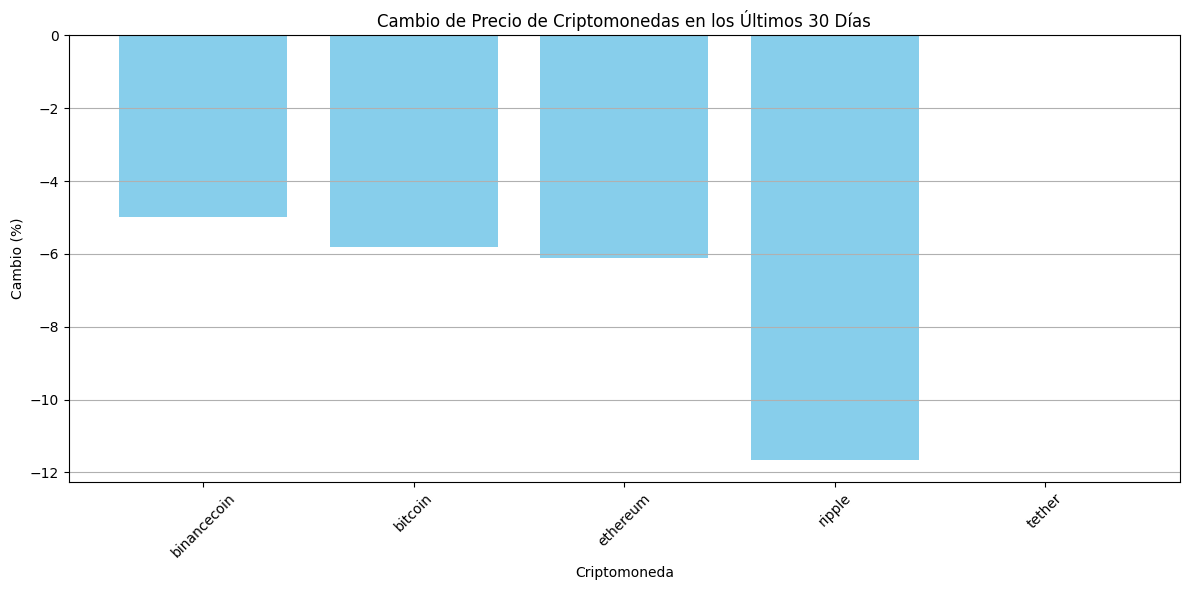

In [10]:
if __name__ == "__main__":
    main()

# Demostracion de como quedarian los df en la capa Gold

In [ ]:
# datos antes de combinar
df_coin_markets_latest = load_silver_coins_markets_latest()
df_coin_markets_latest.head()

📅 Fecha más reciente: 2025-06-19
📊 Registros de la última extracción: 75


,id,symbol,name,extract_date,current_price,market_cap,total_volume,high_24h,low_24h,price_change_24h,price_change_percentage_24h,market_cap_change_24h,market_cap_change_percentage_24h,total_supply,max_supply,ath,ath_date,roi.percentage
0,tron,trx,TRON,2025-06-19,0.274423,26017422698,627320701.0,0.274673,0.268103,0.000958,0.35035,8.382471e+07,0.32323,9.482558e+10,1.000000e+09,0.431288,2024-12-04T00:10:40.323Z,14343.313931
1,cardano,ada,Cardano,2025-06-19,0.604450,21835290862,674979445.0,0.620760,0.590753,-0.011122,-1.80678,-3.886672e+08,-1.74887,4.500000e+10,4.500000e+10,3.090000,2021-09-02T06:00:10.474Z,0.000000
2,hyperliquid,hype,Hyperliquid,2025-06-19,37.900000,12677428036,454524184.0,41.040000,37.810000,-2.274815,-5.66255,-7.365968e+08,-5.49124,9.999904e+08,1.000000e+09,45.570000,2025-06-16T14:36:35.939Z,0.000000
3,ethena-usde,usde,Ethena USDe,2025-06-19,1.000000,5595380353,81451590.0,1.001000,0.998583,0.000178,0.01776,-2.993850e+08,-5.07883,5.594691e+09,1.000000e+09,1.032000,2023-12-20T15:38:34.596Z,0.000000
4,pi-network,pi,Pi Network,2025-06-19,0.537018,4002755366,111022980.0,0.560539,0.525317,-0.022818,-4.07579,-1.743948e+08,-4.17497,1.146659e+10,1.000000e+11,2.990000,2025-02-26T16:41:03.732Z,0.000000


In [19]:
df_markets_chart_latest = load_silver_market_chart_latest()
df_markets_chart_latest.head()

📅 Fecha más reciente: 2025-06-19
📊 Registros de la última extracción: 1085


,coin_id,date,extract_date,prices,market_caps,total_volumes,year_month
0,tether,2025-05-21,2025-06-19,1.0,1.516237e+11,6.805599e+10,2025-05
1,tether,2025-05-22,2025-06-19,1.0,1.519651e+11,1.037940e+11,2025-05
2,tether,2025-05-23,2025-06-19,1.0,1.524294e+11,8.970042e+10,2025-05
3,tether,2025-05-24,2025-06-19,1.0,1.525045e+11,9.650441e+10,2025-05
4,tether,2025-05-25,2025-06-19,1.0,1.527318e+11,4.415471e+10,2025-05


In [9]:
# datos deespués de combinar
df_combined = load_and_combine_crypto_data_for_gold_layer()
df_combined.head()

🔄 Combinando DataFrames...
📅 Fecha más reciente: 2025-06-20
📊 Registros de la última extracción: 50
📅 Fecha más reciente: 2025-06-20
📊 Registros de la última extracción: 155
✅ Combinación exitosa:
   - Total filas: 205
   - Columnas: 19
   - Criptomonedas: 50


,coin_id,symbol,name,extract_date,price,market_cap,total_volume,high_24h,low_24h,price_change_24h,price_change_percentage_24h,market_cap_change_24h,market_cap_change_percentage_24h,total_supply,max_supply,ath,ath_date,roi.percentage,date
0,aave,aave,Aave,2025-06-20,247.200000,3.748009e+09,4.263178e+08,264.020,243.330000,-8.783218,-3.43113,-1.247667e+08,-3.22163,1.600000e+07,1.600000e+07,661.69,2021-05-18T21:19:59.514Z,0.0,2025-06-20
1,aptos,apt,Aptos,2025-06-20,4.260000,2.732592e+09,1.731727e+08,4.470,4.190000,-0.123935,-2.82562,-7.878497e+07,-2.80236,1.149755e+09,1.000000e+09,19.92,2023-01-26T14:25:17.390Z,0.0,2025-06-20
2,avalanche-2,avax,Avalanche,2025-06-20,17.340000,7.315512e+09,3.329535e+08,18.380,17.050000,-0.747227,-4.13212,-3.151607e+08,-4.13018,4.569871e+08,7.200000e+08,144.96,2021-11-21T14:18:56.538Z,0.0,2025-06-20
3,binance-bridged-usdt-bnb-smart-chain,bsc-usd,Binance Bridged USDT (BNB Smart Chain),2025-06-20,0.999745,6.283017e+09,6.465718e+09,1.003,0.997854,-0.000788,-0.07877,-2.452659e+06,-0.03902,6.284994e+09,1.000000e+09,1.05,2024-08-05T14:21:42.527Z,0.0,2025-06-20
4,binancecoin,not available,not available,2025-06-20,674.710000,9.843237e+10,1.565137e+09,-1.000,-1.000000,-1.000000,-1.00000,-1.000000e+00,-1.00000,-1.000000e+00,-1.000000e+00,-1.00,NaN,-1.0,2025-05-22 00:00:00


In [ ]:
# dataframe con agregación de precios
price_change_df = price_change(df_combined)
price_change_df.head()

📊 Calculando market cap y total volume...


,coin_id,first_price,last_price,extract_date,pct_change_30d
0,binancecoin,650.95,645.19,2025-06-19,-0.884861
1,bitcoin,106786.72,104890.81,2025-06-19,-1.775417
2,ethereum,2524.27,2519.54,2025-06-19,-0.187381
3,ripple,2.36,2.16,2025-06-19,-8.474576
4,tether,1.00,1.00,2025-06-19,0.000000


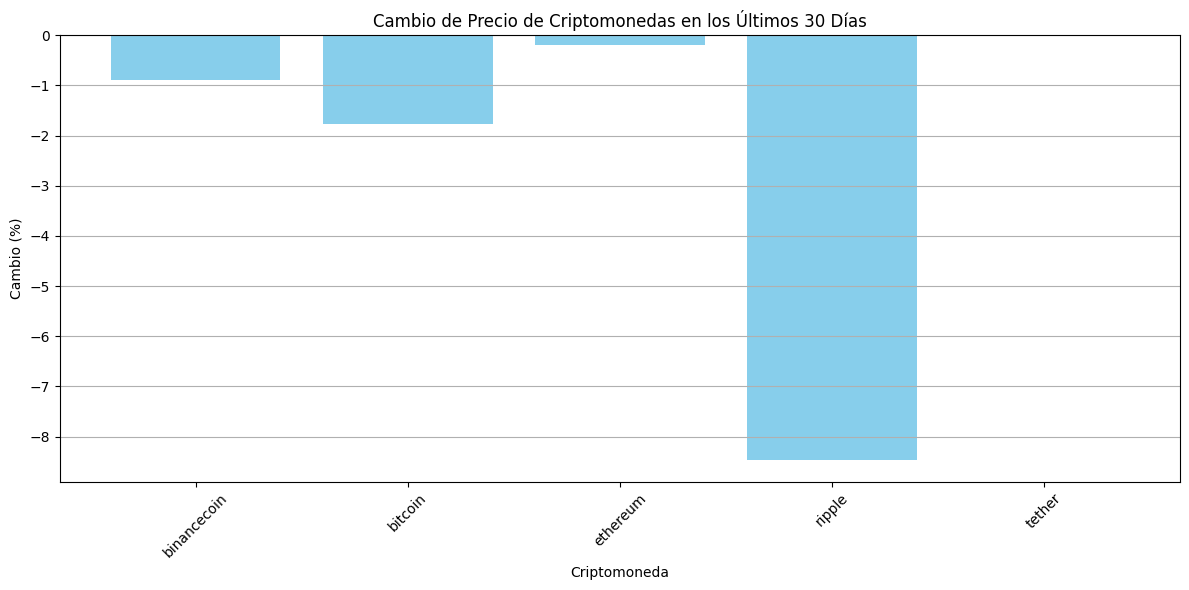

In [ ]:
price_change_visualization(price_change_df)
# en la fecha actual 19/06/2025 podemos ver una caida del precio de las critomonedas mas importantes.